In [18]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
import lightgbm as lgb

In [2]:
train_path = 'data\Train.csv'
train_df = pd.read_csv(train_path)

In [3]:
label_object = {}
encoded_train_df = train_df.copy()
categorical_columns = ['country', 'bank_account', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
for col in categorical_columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(encoded_train_df[col])
    encoded_train_df[col] = labelencoder.fit_transform(encoded_train_df[col])
    label_object[col] = labelencoder

encoded_train_df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,2018,uniqueid_1,1,0,1,3,24,0,5,2,3,9
1,0,2018,uniqueid_2,0,0,0,5,70,0,1,4,0,4
2,0,2018,uniqueid_3,1,1,1,5,26,1,3,3,5,9
3,0,2018,uniqueid_4,0,0,1,5,34,0,1,2,2,3
4,0,2018,uniqueid_5,0,1,0,8,26,1,0,3,2,5


In [4]:
# Split into features (X) and the target variable (y)
X = encoded_train_df.drop('bank_account', axis=1)
X = X.drop('uniqueid', axis=1)
y = encoded_train_df['bank_account']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
column_list = X_train.columns.tolist()

[08:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



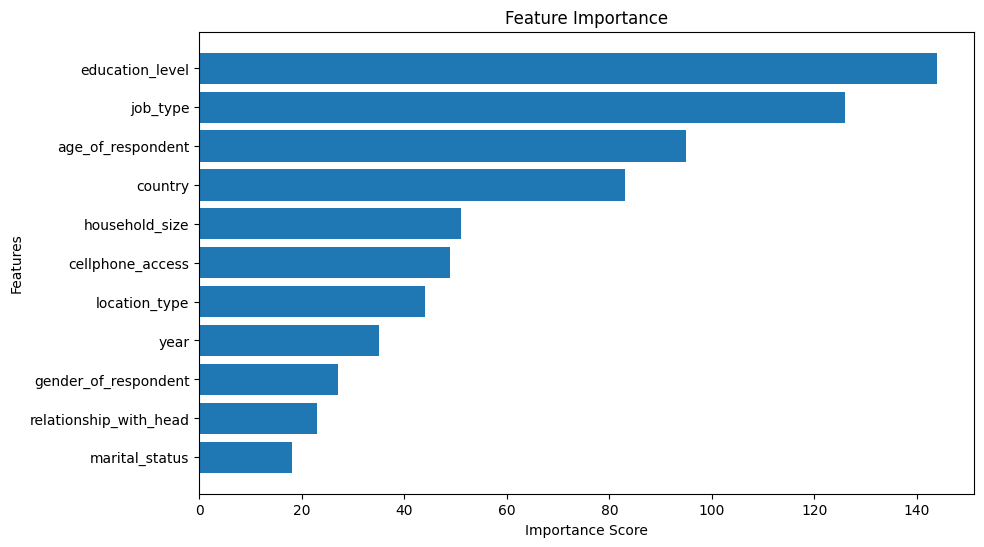

In [7]:
# Create DMatrix data structure for efficient training
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set hyperparameters
params = {
    'objective': 'reg:squarederror',  # Objective for regression task
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Get feature importance scores
importance_scores = bst.get_fscore()

# Sort feature importances in descending order
sorted_importances = sorted(importance_scores.items(), key=lambda x: x[1], reverse=False)

# Separate feature names and importance scores
feature_names, importance_scores = zip(*sorted_importances)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), importance_scores, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [8]:
# Create an XGBoost classifier instance
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    eval_metric='auc',
    early_stopping_rounds=10  # Set the early_stopping_rounds parameter here
)


# Fit the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# Get the optimal number of estimators based on early stopping
optimal_n_estimators = xgb_model.best_iteration
print(f'Optimal n_estimators: {optimal_n_estimators}')

[0]	validation_0-auc:0.82649
[1]	validation_0-auc:0.83598
[2]	validation_0-auc:0.84910
[3]	validation_0-auc:0.84758
[4]	validation_0-auc:0.84948
[5]	validation_0-auc:0.84989
[6]	validation_0-auc:0.85097
[7]	validation_0-auc:0.85602
[8]	validation_0-auc:0.85663
[9]	validation_0-auc:0.85604
[10]	validation_0-auc:0.85665
[11]	validation_0-auc:0.85585
[12]	validation_0-auc:0.85682
[13]	validation_0-auc:0.85926
[14]	validation_0-auc:0.85818
[15]	validation_0-auc:0.86172
[16]	validation_0-auc:0.86364
[17]	validation_0-auc:0.86501
[18]	validation_0-auc:0.86501
[19]	validation_0-auc:0.86507
[20]	validation_0-auc:0.86474
[21]	validation_0-auc:0.86480
[22]	validation_0-auc:0.86489
[23]	validation_0-auc:0.86470
[24]	validation_0-auc:0.86468
[25]	validation_0-auc:0.86543
[26]	validation_0-auc:0.86720
[27]	validation_0-auc:0.86701
[28]	validation_0-auc:0.86718
[29]	validation_0-auc:0.86730
[30]	validation_0-auc:0.86758
[31]	validation_0-auc:0.86920
[32]	validation_0-auc:0.86888
[33]	validation_0-au

# Determine optimal max_depth and min_child_weight parameters

In [9]:
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=65,
        max_depth=2,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test1,
    scoring='roc_auc',
    n_jobs=4,
    cv=5
)

gsearch1.fit(X_train, y_train)

print("Best parameters:", gsearch1.best_params_)
print("Best score:", gsearch1.best_score_)

Best parameters: {'max_depth': 5, 'min_child_weight': 1}
Best score: 0.8623137357892496


# Tune gamma paramter

In [10]:
param_test3 = {
    'gamma': [i/20.0 for i in range(0, 8)]
}

gsearch3 = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140,
        max_depth=5,
        min_child_weight=1,
        gamma=0.0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test3,
    scoring='roc_auc',
    n_jobs=4,
    cv=5
)

gsearch3.fit(X_train, y_train)

print("Best parameters:", gsearch3.best_params_)
print("Best score:", gsearch3.best_score_)


Best parameters: {'gamma': 0.35}
Best score: 0.8614039768797163


# Tune subsample and colsample_bytree parameters

In [11]:
param_test4 = {
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)]
}

gsearch4 = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=177,
        max_depth=5,
        min_child_weight=1,
        gamma=0.35,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27
    ),
    param_grid=param_test4,
    scoring='roc_auc',
    n_jobs=4,
    cv=5
)

gsearch4.fit(X_train, y_train)

print("Best parameters:", gsearch4.best_params_)
print("Best score:", gsearch4.best_score_)


Best parameters: {'colsample_bytree': 0.6, 'subsample': 0.8}
Best score: 0.8617712222242776


In [12]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(learning_rate =0.05,
                            n_estimators=140,
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0.35,
                            subsample=0.8,
                            colsample_bytree=0.6,
                            nthread=4,
                            scale_pos_weight=1,
                            seed=27
                            )

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.35, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [13]:
y_pred = xgb_model.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8930924548352817
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4063
           1       0.73      0.35      0.47       642

    accuracy                           0.89      4705
   macro avg       0.82      0.66      0.71      4705
weighted avg       0.88      0.89      0.88      4705

Confusion Matrix:
[[3979   84]
 [ 419  223]]


In [20]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

0.10690754516471838


In [45]:
test_df = pd.read_csv('data\Test.csv')
test_input_df = test_df.copy()
test_input_df.drop('uniqueid', axis=1, inplace=True)
test_input_df.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [46]:
label_object = {}
encoded_test_df = test_input_df.copy()
categorical_columns = ['country', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
for col in categorical_columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(encoded_test_df[col])
    encoded_test_df[col] = labelencoder.fit_transform(encoded_test_df[col])
    label_object[col] = labelencoder

encoded_test_df.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,2018,1,1,3,30,1,1,2,3,2
1,0,2018,1,1,7,51,1,1,2,5,3
2,0,2018,0,0,3,77,0,4,2,0,8
3,0,2018,0,0,6,39,0,1,2,2,8
4,0,2018,1,0,3,16,1,0,3,3,8


In [47]:
y_test_pred = xgb_model.predict(encoded_test_df)
print(y_test_pred.shape)

(10086,)


In [48]:
test_df['unique_id'] = test_df['uniqueid'] + ' x ' + test_df['country']
test_df['bank_account'] = y_test_pred
test_df.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,unique_id,bank_account
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,uniqueid_6056 x Kenya,1
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,uniqueid_6060 x Kenya,1
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,uniqueid_6065 x Kenya,0
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,uniqueid_6072 x Kenya,0
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,uniqueid_6073 x Kenya,0


In [ ]:
submission_df = test_df[]